In supervised learning algorithms, we generally have some model (such as a neural network) with a set of parameters (the weights), a data set, and an error function which measures how well our parameters and model fit the data. With many models, the way to train the model and fit the parameters is through an iterative minimization procedure which uses the gradient of the error to find the local minimum in parameter space. This notebook will not go into the details of neural networks or how to compute the derivatives of error functions, but instead focuses on some of the simple minimization methods one can employ. The goal of this notebook is to develop a simple yet flexible framework in Haskell in which we can develop gradient descent methods.

Although you should keep in mind that the goal of these algorithms (for our purposes) is to train neural networks, for now we will just discuss some abstract function $f(\vec x)$ for which we can compute all partial derivatives.
$\newcommand\vector[1]{\langle #1 \rangle}\newcommand\p[2]{\frac{\partial #1}{\partial #2}}$

Gradient Descent
---
The simplest algorithm for iterative minimization of differentiable functions is known as just **gradient descent**.
Recall that the gradient of a function is defined as the vector of partial derivatives:

$$\nabla f(x) = \vector{\p{f}{x_1}, \p{f}{x_2}, \ldots, \p{f}{x_n}}$$

and that the gradient of a function always points towards the direction of maximal increase at that point.

Equivalently, it points *away* from the direction of maximum decrease - thus, if we start at any point, and keep moving in the direction of the negative gradient, we will eventually reach a local minimum.

This simple insight leads to the Gradient Descent algorithm. Outlined algorithmically, it looks like this:

1. Pick a point $x_0$ as your initial guess.
2. Compute the gradient at your current guess:
$v_i = \nabla f(x_i)$
3. Move by $\alpha$ (your step size) in the direction of that gradient:
$x_{i+1} = x_i + \alpha v_i$
4. Repeat steps 1-3 until your function is close enough to zero (until $f(x_i) < \varepsilon$ for some small tolerance $\varepsilon$)

Note that the step size, $\alpha$, is simply a parameter of the algorithm and has to be fixed in advance. 

Though this algorithm is simple, it will be a bit of a challenge to formalize it into executable Haskell code that we can later extend to other algorithms. First, note that gradient descent requires two things:

- Something to optimize (a function)
- What to optimize over (the parameters)
- A way to compute partials of the function

Note that we don't actually need to *call* the function itself - only the partial derivatives are necessary.

We're going to define a single class for things on which we can run gradient descent. Although later we may want to modify this class, this serves as a beginning:

In [1]:
:set -XTypeFamilies
class GradientDescent a where
  -- Type to represent the parameter space.
  data Params a :: *
  
  -- Compute the gradient at a location in parameter space.
  grad :: a -> Params a -> Params a
  
  -- Move in parameter space.
  paramMove :: Double    -- Scaling factor.
            -> Params a  -- Direction vector.
            -> Params a  -- Original location.
            -> Params a  -- New location.

In order to use some type `a` with our gradient descent, we require that it is an instance of `GradientDescent`. This class requires a few things.

First off, we use type families in order to define a representation for the parameter space. We want to be able to operate on points in the parameter space of our function; however, while something like a list of values might be nice and simple in one case, it is inappropriate and inefficient when storing the weights of a neural network. Thus, we let each class instance decide how to store its parameters by defining an associated type instance. (We will see an instance of this later!)

Next, `GradientDescent` requires a single function called `grad`, which takes the thing of type `a` and the current point in parameter space (via a `Param a`) and outputs a set of partial derivatives. The partial derivatives have the same form and dimension as the point in parameter space, so they are also a `Param a`. 

Finally, we must be able to move around in parameter space, so `GradientDescent` defines a function `paramMove` which does exactly that - it takes a parameter vector and an amount by which to move and uses these to generate a new position from an old one.

Let's go ahead and create the simplest instantiation of this class and type family: a single-argument function. Note that this is just for demo purposes, and we're going to use numerical differentiation to compute the derivative.

In [2]:
-- We need flexible instances for declarations like these.
:set -XFlexibleInstances

instance Floating a => GradientDescent (a -> a) where
  -- The parameter for a function is just its argument.
  data Params (a -> a) = Arg { unArg :: a }

  -- Use numeric differentiation for taking the gradient.
  grad f (Arg value) = Arg $ (f value - f (value - epsilon)) / epsilon
    where epsilon = 0.0001
    
  paramMove scale (Arg vec) (Arg old) = Arg $ old + fromRational (toRational scale) * vec

We're getting closer to implementing the actual algorithm. However, we have yet to define when the algorithm *stops* - and, in order to give maximum flexibility to the user, we'll let the stopping condition be an argument. This lets the user specify an error tolerance, as well as how they want to derive this error:

In [3]:
-- Define a way to decide when to stop.
-- This lets the user specify an error tolerance easily.
-- The function takes the previous two sets of parameters and returns
-- `True` to continue the descent and `False` to stop.
newtype StopCondition a = StopWhen (Params a -> Params a -> Bool)

With a single instance of our class, we can now implement our gradient descent algorithm:

In [4]:
gradientDescent :: GradientDescent a => a  -- What to optimize.
                -> StopCondition a        -- When to stop.
                -> Double                 -- Step size (alpha).
                -> Params a               -- Initial point (x0).
                -> Params a               -- Return: Location of minimum.
gradientDescent function (StopWhen stop) alpha x0 =
  let iterations = iterate takeStep x0
      iterationPairs = zip iterations $ tail iterations
    in
      -- Drop all elements where the resulting parameters (and previous parameters)
      -- do not meet the stop condition. Then, return just the last parameter set.
      snd . head $ dropWhile (not . uncurry stop) iterationPairs
  where
    -- For each step...
    takeStep params = 
      -- Compute the gradient.
      let gradients = grad function params in
        -- And move against the gradient with a step size alpha.
        paramMove (-alpha) gradients params

Let's go ahead and try this for some simple functions. First, we need to create a stopping condition. In this case, we're going to stop when successive updates to the parameters do not affect the outcome very much - namely, when the difference between the function value at successive parameters is below some $\varepsilon$-tolerance. In other scenarios, we may want to use a more complicated stopping criterion.

In [5]:
-- Create a stop condition that respects a given error tolerance.
stopCondition :: (Double -> Double) -> Double -> StopCondition (Double -> Double)
stopCondition f tolerance = StopWhen stop
  where stop (Arg prev) (Arg cur) =
          abs (f prev - f cur) < tolerance  

Let's finally try to minimize something, such as the relatively trivial function $f(x) = x^2 + 3x$. It's graph looks like this:

<center>
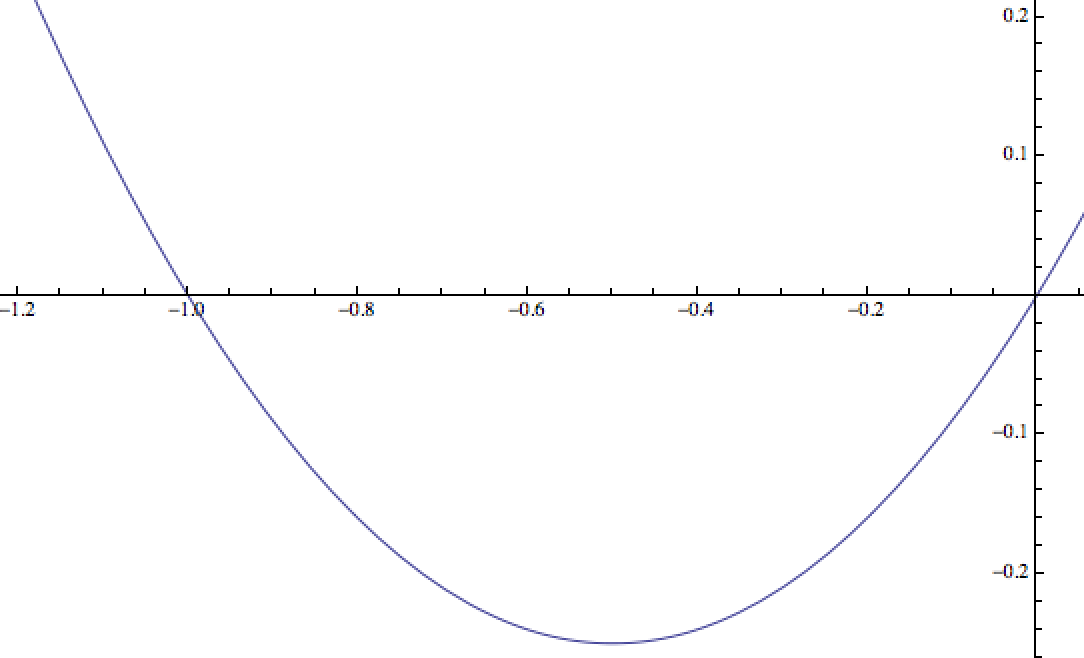
</center>

This function has a minimum at $x = -\frac{3}{2}$.

In [6]:
-- A demo function with minimum at -3/2
function x = x^2 + 3 * x

Finally, let's take the minimum. We're going to use a step size of $\alpha = 0.1$, start at $x_0 = 12$, and stop with a tolerance of $1\times 10^{-4}$:

In [7]:
let alpha = 1e-1
let tolerance = 1e-4
let initValue = 12.0
unArg $ gradientDescent function (stopCondition function tolerance) alpha (Arg initValue)

-1.4892542376755242

Monadic Gradient Descent
---

Although the above implementation of gradient descent works, we're going to run into problems when our functions are more complicated. For instance, suppose that computing the gradient required a lot of computation, and the computation required communicating with a distributed network of processing nodes. Or suppose that there were some regimes in which the function was non-differentiable, and we wanted to use the `Maybe` type to represent this. In order to support this, we can try to rewrite our class with *monadic* variants of its operations.

In [8]:
:set -XMultiParamTypeClasses
class Monad m => GradientDescent m a where
  -- Type to represent the parameter space.
  data Params a :: *
  
  -- Compute the gradient at a location in parameter space.
  grad :: a -> Params a -> m (Params a)
  
  -- Move in parameter space.
  paramMove :: Double        -- Scaling factor.
            -> Params a      -- Direction vector.
            -> Params a      -- Original location.
            -> m (Params a)  -- New location.
            
            
-- Since we've redefined GradientDescent, we need to redefine StopCondition.
newtype StopCondition a = StopWhen (Params a -> Params a -> Bool)

In order to utilize this, we're going to have to rewrite our instance to run all computations in a monad. The implementation will look quite familiar, but we won't be able to use as many built-in functions, as they do not have monadic variants in the base packages.

In [9]:
gradientDescent :: (GradientDescent m a) => 
                   a                 -- What to optimize.
                -> StopCondition a   -- When to stop.
                -> Double            -- Step size (alpha).
                -> Params a          -- Initial point (x0).
                -> m (Params a)      -- Return: Location of minimum.
gradientDescent function (StopWhen stop) alpha x0 = do
  -- Take the next step.
  next <- takeStep x0
  
  -- If we stop, do so, otherwise recurse.
  if stop x0 next
     then return next
     else gradientDescent function (StopWhen stop) alpha next
  where
    takeStep params = do
      gradients <- grad function params
      paramMove (-alpha) gradients params

Let's try this for something simple. Suppose we're using our old $f(x) = x^2 + 3x$, but for some reason, we are incapable of differentiating if the function value is below zero. We'll use the `Maybe` monad to represent this - if the parameter to a function is negative, we return `Nothing`, otherwise, we return `Just` the derivative.

In [10]:
instance (Ord a, Floating a) => GradientDescent Maybe (a -> a) where
  -- The parameter for a function is just its argument.
  data Params (a -> a) = Arg { unArg :: a }

  -- Use numeric differentiation for taking the gradient.
  grad f (Arg value) = 
    if value > 0
    then Just $ Arg $ (f value - f (value - epsilon)) / epsilon
    else Nothing
    where epsilon = 0.0001
    
  paramMove scale (Arg vec) (Arg old) = Just $ Arg $ old + fromRational (toRational scale) * vec

Let's go ahead and try this with the same example as before.

In [11]:
stopCondition f tolerance = StopWhen stop
  where stop (Arg prev) (Arg cur) =
          abs (f prev - f cur) < tolerance  
          
let x0 = Arg initValue
let stopper = stopCondition function tolerance
case gradientDescent function stopper alpha x0 of
  Just x -> print $ unArg x
  Nothing -> putStrLn "Nothing!"

Nothing!

We saw in the original example that the minimum is at $-\frac{3}{2}$, so this gradient descent tries to go into the $x < 0$ region - at which point the differentiation returns `Nothing`, and the gradient descent implicitly stops! This monadic gradient descent can be used to implement things such as bounded optimization, optimization that keeps track of the states it went through, optimization that uses networked IO to do its computation, and so on.

That's it for now. In the next notebook, I'm going to try implementing conjugate gradient in this same framework.